In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [5]:
import tensorflow as tf

EPOCHS = 1
BATCH_SIZE = 128

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)

    #Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    probs = tf.nn.softmax(logits)
    return logits, probs

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

In [8]:
rate = 0.001

logits = LeNet(x)[0]
probs = tf.nn.softmax(logits=logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    tf.set_random_seed(40)
    print("Training...")
    print()
    for i in range(EPOCHS):
        tf.set_random_seed(40)
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()    
    saver.save(sess, './lenet')
    print("Model saved")

Training...
()
EPOCH 1 ...
Validation Accuracy = 0.974
()
Model saved


In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.973


In [12]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={x: img})[0]
    print(p)
    ax1.imshow(img_show)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [[i] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [41]:
import matplotlib.pyplot as plt
import PIL
from urllib import urlretrieve
img = X_test[5]

img_class = y_test[5]
#img = PIL.Image.open(img_path)
#new_w = 32 #if not wide else int(img.width * 28 / img.height)
#new_h = 32 #if wide else int(img.height * 28 / img.width)
#img = img.resize((new_w, new_h)).crop((0, 0, 32, 32))
img_show = img.reshape(32,32)
#img_show = (np.asarray(img) / 255.0).astype(np.float32)
img = img_show.reshape(1,32,32,1)

INFO:tensorflow:Restoring parameters from ./lenet
[  2.17540201e-05   9.97013807e-01   7.32538538e-05   2.91897686e-05
   1.11958536e-03   9.26028690e-07   2.50805697e-05   1.40156923e-03
   1.98294598e-04   1.16539813e-04]


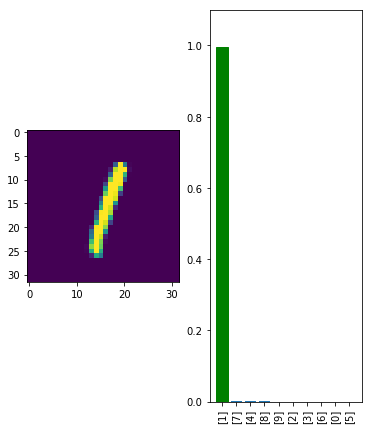

In [42]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classify(img, correct_class=img_class)

In [43]:
x_hat = tf.Variable(tf.zeros((1, 32, 32, 1)))# trainable adversarial input
x_adv =  tf.placeholder(tf.float32, (1, 32, 32, 1))
assign_op = tf.assign(x_hat, x_adv)
logits_hat = LeNet(x_hat)[0]
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ()) # Target label
labels_hat = tf.one_hot(y_hat, 10)
loss_hat = tf.nn.softmax_cross_entropy_with_logits(labels=[labels_hat],logits=logits_hat)
optim_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_hat, var_list=[x_hat])

In [44]:
epsilon = tf.placeholder(tf.float32, ())

below = x_adv - epsilon
above = x_adv + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [45]:
# initialization step
with tf.Session() as sess:
    demo_epsilon = 1 # a really small perturbation
    demo_lr = 5
    demo_steps = 2000
    demo_target = 2 
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(assign_op, feed_dict={x_adv: img})
# projected gradient descent
    for i in range(demo_steps):
    # gradient descent step
        _, loss_value = sess.run([optim_step, loss_hat],feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
        sess.run(project_step, feed_dict={x_adv: img, epsilon: demo_epsilon})
        if (i+1) % 100 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))
    adv = x_hat.eval() # retrieve the adversarial example

step 100, loss=0.966911
step 200, loss=0.979258
step 300, loss=0.977624
step 400, loss=0.917836
step 500, loss=0.91407
step 600, loss=0.91362
step 700, loss=0.930182
step 800, loss=0.924566
step 900, loss=0.915532
step 1000, loss=0.886288
step 1100, loss=0.907268
step 1200, loss=0.913208
step 1300, loss=0.867934
step 1400, loss=0.867218
step 1500, loss=0.856851
step 1600, loss=0.84466
step 1700, loss=0.854492
step 1800, loss=0.872777
step 1900, loss=0.848914
step 2000, loss=0.851081


INFO:tensorflow:Restoring parameters from ./lenet
[  1.09443543e-02   7.94222578e-05   2.53990595e-03   3.04189918e-04
   4.47286572e-03   3.57286888e-04   7.48573057e-03   6.96191710e-05
   9.72428501e-01   1.31810189e-03]


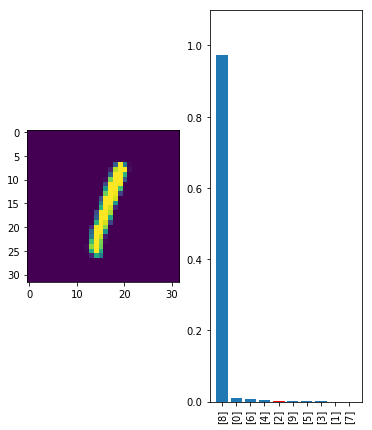

[  2.17540201e-05   9.97013807e-01   7.32538538e-05   2.91897686e-05
   1.11958536e-03   9.26028690e-07   2.50805697e-05   1.40156923e-03
   1.98294598e-04   1.16539813e-04]


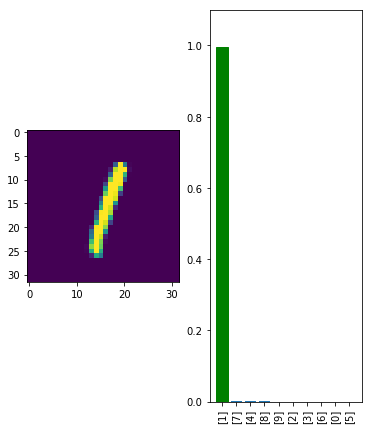

In [46]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classify(adv, correct_class=img_class,target_class=demo_target)
    classify(img, correct_class=img_class,target_class=demo_target)

In [51]:
import cv2

img_aug = X_test[5]


height, width = img.shape[:2]
res = cv2.resize(img,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)

ImportError: dlopen(/Users/JeremyNie/anaconda3/envs/attack/lib/python2.7/site-packages/cv2/cv2.so, 2): Symbol not found: _clock_gettime
  Referenced from: /Users/JeremyNie/anaconda3/envs/attack/lib/python2.7/site-packages/cv2/.dylibs/libavutil.55.78.100.dylib (which was built for Mac OS X 10.12)
  Expected in: /usr/lib/libSystem.B.dylib
 in /Users/JeremyNie/anaconda3/envs/attack/lib/python2.7/site-packages/cv2/.dylibs/libavutil.55.78.100.dylib